
# 3_Filtros: Pasa Altos + Pasa Bajos

Un buen filtrado del ECG se cosigue eliminando frecuencias menor a 0,5Hz y mayores a 30Hz ya que (...). Para lograr esto 

En primer lugar se generó un filtro pasa bandas con la funcion firls, a la cual se le pasaban las frecuencias de corte y las ganancias correspondientes. Esto generó un problema ya que el salto que debe dar a frecuencias bajas es muy abrupto, por lo que se decidió recurrir a desarrollarlo mediante la convolución de un filtro pasa bajos y  un pasa altos, y así asignarle a cada uno la cantidad de coeficientes necesarios para obtener la respuesta buscada.
Ambos filtros se desarrollaron con la función firls como se muestra a continuación

Nota: La primera prueba de este filtro se hizo con las señales de ECG de la base de datos del MIT, cuya frecuencia de muestreo es 360Hz, cuando se buscó hacer el analisis de un ECG obtenido durante una prueba de esfuerzo que se muetreo a una frecuencia de 1000Hz se tuvo que aumentar la cantidad de coeficientes utlizados, ya que al aumentar la frecuencia de nyquist los saltos en frecuencia representaban un menor porcentaje de la respuesta 

In [6]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,12)
from pandas import DataFrame
from IPython.display import HTML

import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio


#------APERTURA DE LA SEÑAL-------
mat_struct = sio.loadmat('/home/luciasucunza/git_proyecto_ecg/Filtros/TP4_ecg.mat')

ecg_one_lead  = mat_struct['ecg_lead']
ecg_one_lead  = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000
nyq_frec = fs / 2

In [7]:
#------DISEÑO DE FILTROS y PLANTILLA-------
ripple = -0.05
atenua = -40.

#------Pasa Bajos-------
wpb_p           = 20.0          #Hz
wpb_s           = 30.0          #Hz
cant_coef_pb    = 501

frecs_pb        = np.array([0.0,    wpb_p,  wpb_s,  nyq_frec ])
gainsDB_pb      = np.array([ripple, ripple, atenua, atenua   ])
gains_pb        = 10**(gainsDB_pb/20)

fir_coeff_pb    = sig.firls( cant_coef_pb, frecs_pb, gains_pb, fs=fs )
w_pb, hh_fir_pb = sig.freqz( fir_coeff_pb, 1 )
w_pb            = w_pb / np.pi * nyq_frec


#------Pasa Altos-------
wpa_s           = 0.2          #Hz
wpa_p           = 3.0          #Hz
cant_coef_pa    = 401

frecs_pa        = np.array([0.0,    wpa_s,  wpa_p,  nyq_frec ])
gainsDB_pa      = np.array([atenua, atenua, ripple, ripple   ])
gains_pa        = 10**(gainsDB_pa/20)

fir_coeff_pa    = sig.firls( cant_coef_pa, frecs_pa, gains_pa, fs=fs )
w_pa, hh_fir_pa = sig.freqz( fir_coeff_pa, 1 )
w_pa            = w_pa / np.pi * nyq_frec


#------Plantilla-------
frecs   = np.array([ 0.0,    wpa_s,  wpa_p,  wpb_p,  wpb_s,  nyq_frec ])
gainsDB = np.array([ atenua, atenua, ripple, ripple, atenua, atenua   ])


#------PA * PB-------
fir_coeff = sig.convolve( fir_coeff_pa, fir_coeff_pb, method = 'direct')
_, hh_fir = sig.freqz( fir_coeff, 1 )

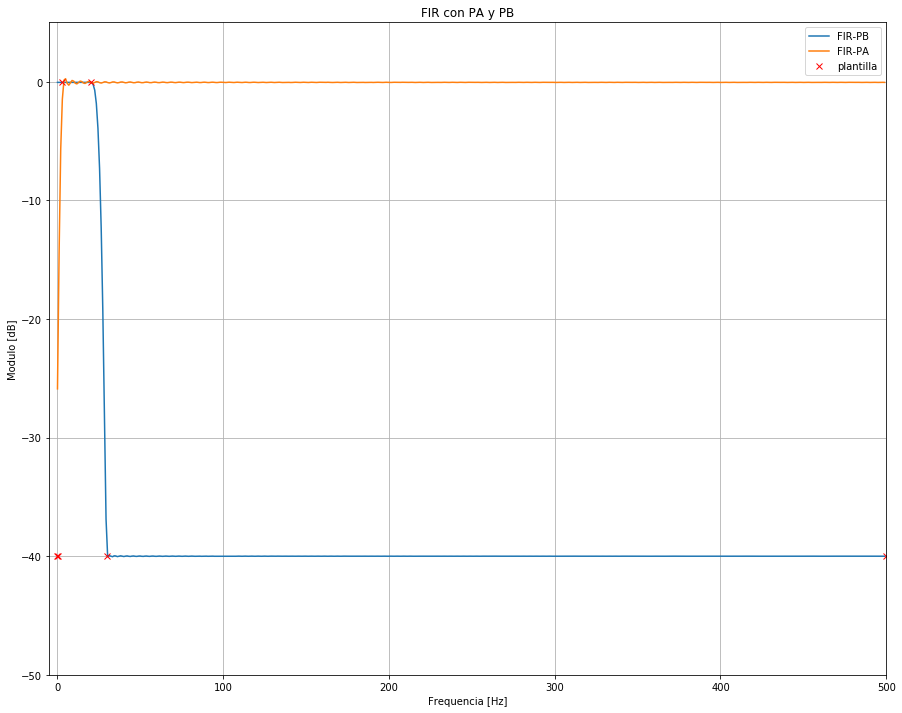

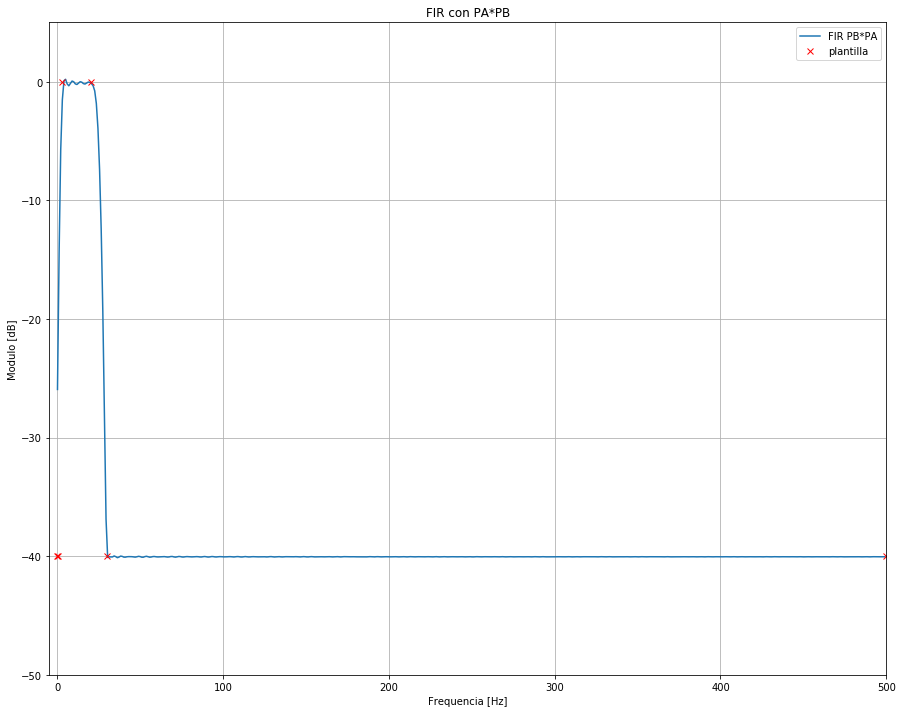

In [8]:
#------PLOTEO DE LAS RESPUESTAS-------
plt.figure(1)
plt.plot(w_pb,     20 * np.log10(abs(hh_fir_pb)),      label='FIR-PB')
plt.plot(w_pa,     20 * np.log10(abs(hh_fir_pa)),      label='FIR-PA')
plt.plot(frecs, gainsDB, 'rx',                      label='plantilla' )

plt.title('FIR con PA y PB' )
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.axis([-5, nyq_frec, -50, 5])

plt.legend()
plt.grid()
plt.show()


plt.figure(2)
plt.plot( w_pa, 20 * np.log10(abs(hh_fir)),    label='FIR PB*PA')
plt.plot( frecs, gainsDB, 'rx',              label='plantilla' )

plt.title('FIR con PA*PB' )
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.axis([-5, nyq_frec, -50, 5])

plt.legend()
plt.grid()
plt.show() 

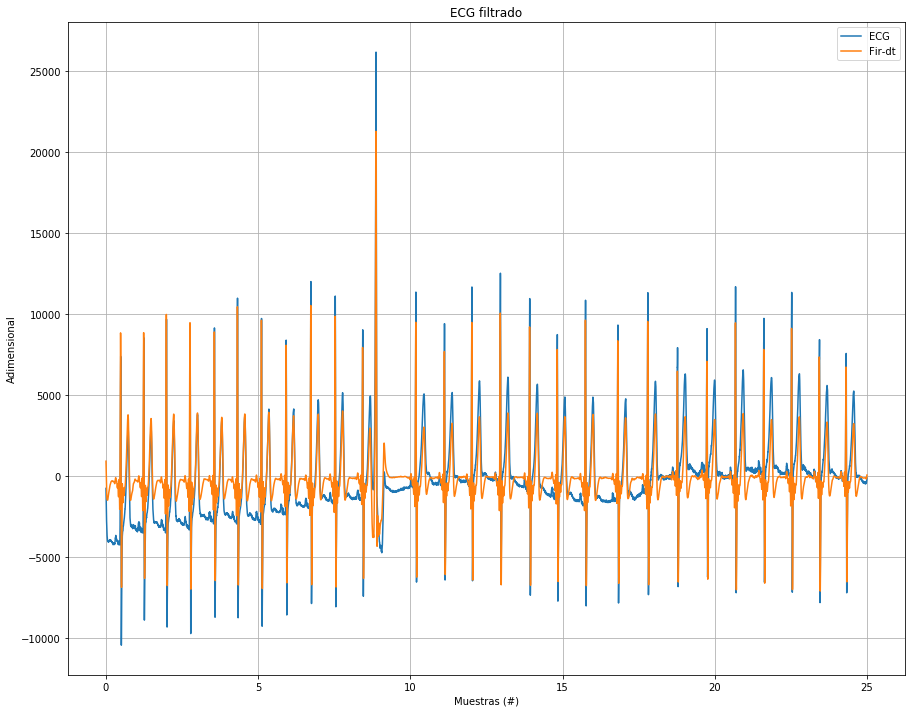

In [9]:
#------FILTRADO DE LA SEÑAL-------
ECG_f_PBPA    = sig.lfilter(fir_coeff, 1, ecg_one_lead)
ECG_f_PBPA_dt = np.zeros(cant_muestras)

t = np.arange(cant_muestras) / fs

c = int((cant_coef_pa+cant_coef_pb)/2)

for i in range (0, cant_muestras-c-1):
    ECG_f_PBPA_dt[i] = ECG_f_PBPA[ i + c]
    
for i in range (cant_muestras-c, cant_muestras-1):
    ECG_f_PBPA_dt[i] = 0  

#------PLOTEO-------
zoom_region = np.arange( 0, 25000, dtype='uint')

plt.figure(3)
plt.plot( t[zoom_region], ecg_one_lead[zoom_region],     label='ECG'     )
plt.plot( t[zoom_region], ECG_f_PBPA_dt[zoom_region],    label='Fir-dt'  )

plt.title('ECG filtrado')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()       


plt.grid()
plt.show()

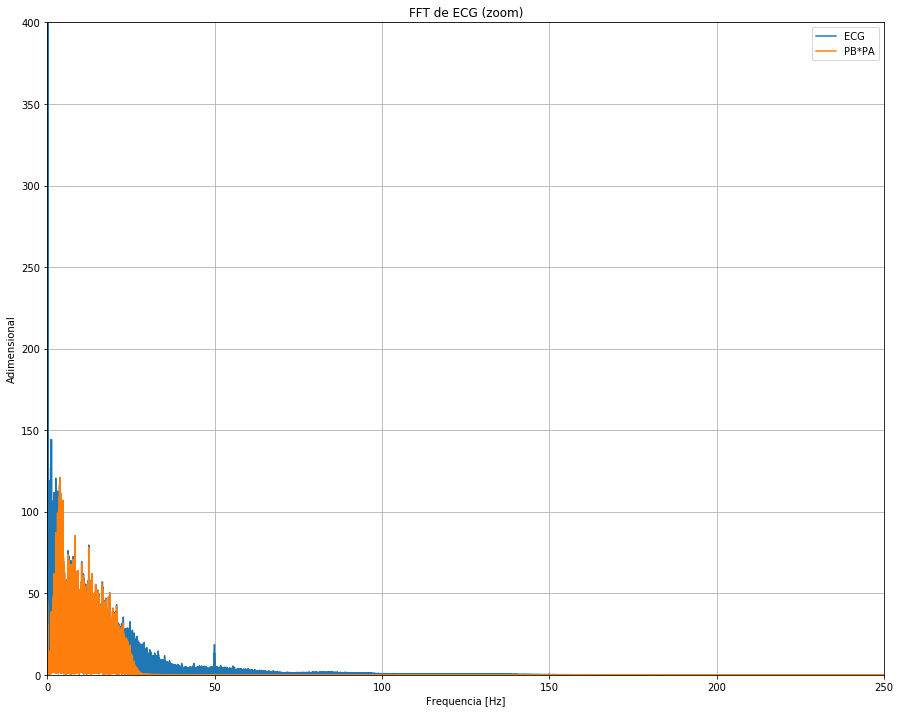

In [10]:
#------CALCULO DE LA FFT -------
resf   = fs/cant_muestras                                 
rangof = np.arange( 0, fs, resf)         

FFT_ecg_one_lead = np.fft.fft( ecg_one_lead )
FFT_ECG_f_PBPA   = np.fft.fft( ECG_f_PBPA   )              

rangof = rangof[range(cant_muestras//2)]     

FFT_ecg_one_lead = abs(FFT_ecg_one_lead[range(cant_muestras//2)] ) / (cant_muestras//2)    
FFT_ECG_f_PBPA   = abs(FFT_ECG_f_PBPA[range(cant_muestras//2)]   ) / (cant_muestras//2)  


#-------PLOTEO--------         
plt.figure(4)
plt.plot( rangof, FFT_ecg_one_lead,   label='ECG')
plt.plot( rangof, FFT_ECG_f_PBPA,     label='PB*PA')

plt.title('FFT de ECG (zoom)')
plt.ylabel('Adimensional')
plt.xlabel('Frequencia [Hz]')
plt.axis([-0.01, nyq_frec/2, -0.01, 400 ])
plt.legend()

plt.grid()
plt.show()

Si bien a grandes rasgos parece haber eliminado la linea de base de forma correcta, sin modificar a grandes rasgos la forma de onda y las amplitudes, se realiza un segundo ploteo de la señal, esta vez con una menor cantidad de muestras para poder analizar mejor la señal

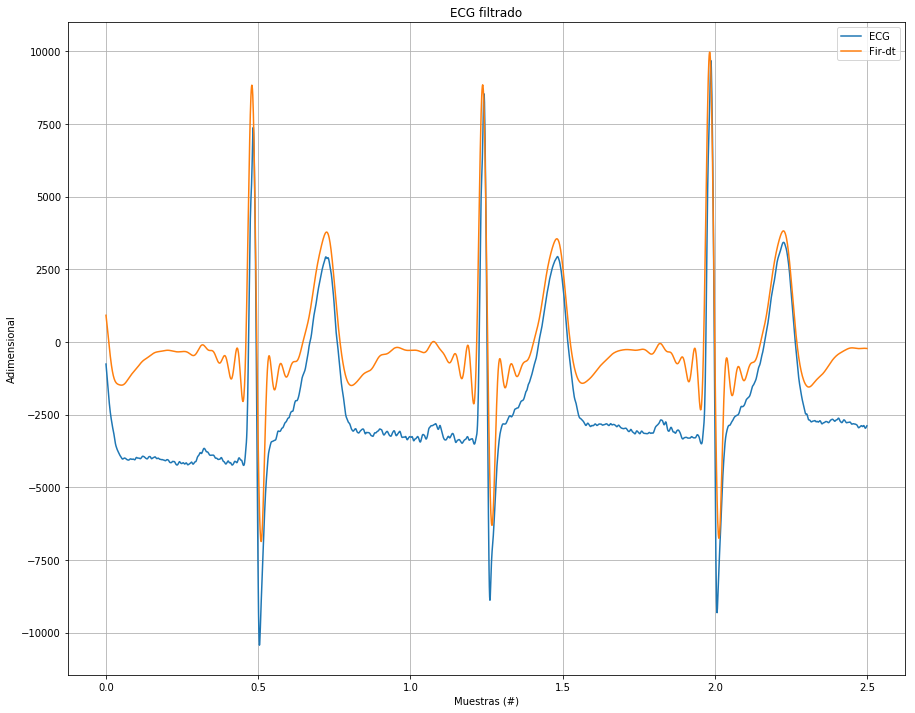

In [11]:
#------PLOTEO-------
zoom_region = np.arange( 0, 2500, dtype='uint')

plt.figure(3)
plt.plot( t[zoom_region], ecg_one_lead[zoom_region],     label='ECG'     )
plt.plot( t[zoom_region], ECG_f_PBPA_dt[zoom_region],    label='Fir-dt'  )

plt.title('ECG filtrado')
plt.ylabel('Adimensional')
plt.xlabel('Muestras (#)')
plt.legend()       

plt.grid()
plt.show()

Con esta vista se puede notar como este metodo no es adecuado, ya que introduce ringing en las cercanías del complejo QRS y distorciona la onda P de forma que es imposible reconocer. En los siguientes scripts se tratará de lograr un buen filtrado sin modifcar estos aspectos tan importantes en un ECG